*Antonio Coín Castro*


# Bayesian Functional Linear Regression

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display, Math

import corner
import sys
import pickle
from multiprocessing import Pool
sys.path.append("..")
import flr

In [2]:
%matplotlib notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 4]

seed = 42
np.random.seed(seed)
np.set_printoptions(precision=3, suppress=True)
rng = np.random.default_rng(seed)

Writing the parameter vector as $\theta = (\beta, \tau, \sigma^2)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \sigma^2\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \sigma^2\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y- \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

## Example dataset

We generate a toy dataset with $n=500$ functional regressors $X_i(t) \sim BM$ and a "simple" RKHS function

$$
Y_i \sim \mathcal N(-5X_i(0.1) + 10X_i(0.8), 0.5).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$.

In [3]:
def brownian_kernel(s, t, sigma=1.0):
    return sigma*np.minimum(s, t)


def cov_matrix(kernel_fn, s, t):
    ss, tt = np.meshgrid(s, t, indexing='ij')

    # Evaluate the kernel over meshgrid (vectorized operation)
    K = kernel_fn(ss, tt)

    return K


def generate_gp_dataset(grid, kernel_fn, n_samples, beta, tau, var_error):
    """Generate dataset based on GP with a given kernel function."""
    N = len(grid)
    p = len(beta)
    mean_vector = np.zeros(N)
    kernel_matrix = cov_matrix(kernel_fn, grid, grid)
    idx = np.abs(np.subtract.outer(grid, tau)).argmin(0)

    X = rng.multivariate_normal(mean_vector, kernel_matrix, size=n_samples)
    X_tau = X[:, idx]
    error = np.sqrt(var_error)*rng.standard_normal(size=n_samples)
    Y = X_tau@beta + error

    return X, Y

In [4]:
t = np.linspace(0, 1, 100)
beta = np.array([-5., 10.])
tau = np.array([0.1, 0.8])
var_error = 0.5
n = 500

X, Y = generate_gp_dataset(t, brownian_kernel, n, beta, tau, var_error)

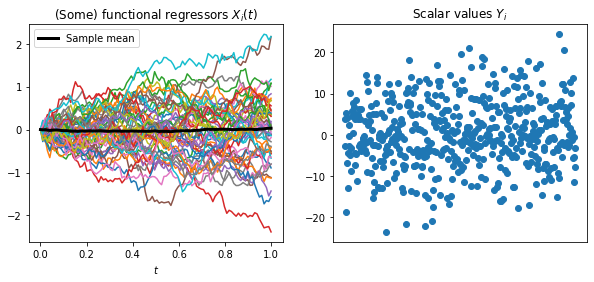

In [5]:
fig, axs = plt.subplots(1, 2)

axs[0].set_title(r"(Some) functional regressors $X_i(t)$")
axs[0].set_xlabel(r"$t$")
axs[0].plot(t, X.T[:, :50])
axs[0].plot(
    t, np.mean(X, axis=0),
    linewidth=3, color='k',
    label="Sample mean")
axs[0].legend()
axs[1].set_title(r"Scalar values $Y_i$")
axs[1].set_xticks([])
axs[1].scatter(range(n), Y)
plt.show()

## The Ensemble Sampler and the *emcee* library

In [6]:
import emcee

In [7]:
# Constant parameters are global for efficient parallelization
def log_prob(theta):
    n, N = X.shape
    p = len(b0)
    beta = theta[:p]
    b = beta - b0
    tau = theta[p:2*p]
    sigma2 = theta[-1]

    # Impose constraints on parameters
    if (tau < 0).any() or (tau > 1).any() or sigma2 <= 0:
        return -np.inf

    idx = np.abs(np.subtract.outer(grid, tau)).argmin(0)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    det = np.linalg.det(G_tau)

    # For the time being, ignore poor conditioning on G
    if not np.isfinite(det) or det <= 0:
        return -np.inf

    log_posterior = (0.5*np.log(det)
                     - (p + n + 2)*np.log(np.sqrt(sigma2))
                     - 0.5*(1./sigma2)*(np.linalg.norm(Y - X_tau@beta)**2
                                        + (1./g)*b.T@G_tau@b))

    # Avoid unexpected errors
    if np.isfinite(log_posterior):
        return log_posterior
    else:
        return -np.inf


def initial_guess(n_walkers, p, g):
    return np.hstack((
        g*rng.standard_normal(size=(n_walkers, p)),
        rng.uniform(size=(n_walkers, p)),
        2*rng.random(size=(n_walkers, 1))
    ))

We try to recover the underlying model considering $p=3$.

In [8]:
p = 3
n_dim = 2*p + 1
n_walkers = 200
n_iter_initial = 200
n_iter = 20000
g = n
b0 = g*rng.standard_normal(size=p)
p0 = initial_guess(n_walkers, p, g)
grid = t

In [9]:
with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_prob, pool=pool)
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress=True)  # burn-in phase
    sampler.reset()
    sampler.run_mcmc(state, n_iter, progress=True)

100%|██████████| 20000/20000 [20:46<00:00, 16.05it/s]


In [10]:
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.2f}%")
print(
    f"Autocorrelation times: {sampler.get_autocorr_time()}")

Mean acceptance fraction: 34.56%
Autocorrelation times: [165.085 139.253 121.068 167.567 101.743 179.907 258.747]


We analyze the samples of all chains, discarding the first 200 and then taking only every 20th sample.

In [19]:
samples = sampler.get_chain(discard=500, thin=20)     # Separate chains
samples_flat = samples.reshape(-1, samples.shape[-1])  # All chains combined
samples_all = sampler.get_chain(discard=500)           # No thinning performed
samples_all_flat = samples_all.reshape(-1, samples_all.shape[-1])

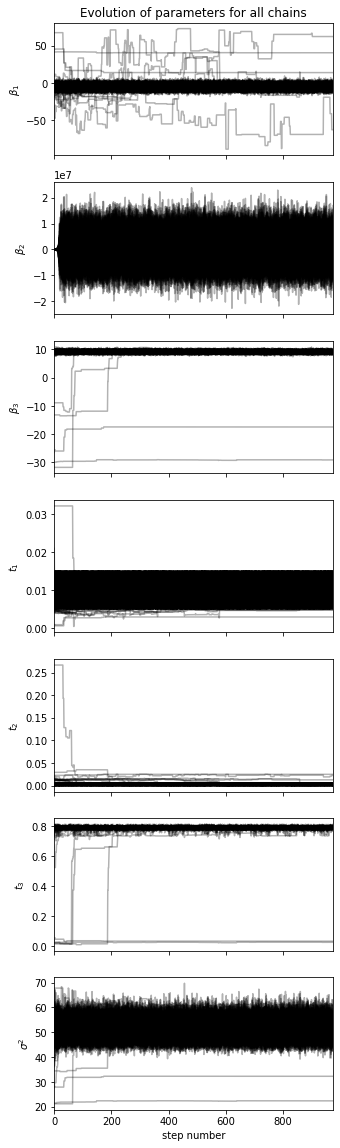

In [21]:
fig, axes = plt.subplots(n_dim, figsize=(5, 20), sharex=True)
labels = [r"$\beta_1$", r"$\beta_2$", r"$\beta_3$",
          r"$t_1$", r"$t_2$", r"$t_3$", r"$\sigma^2$"]

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(samples))

axes[0].set_title("Evolution of parameters for all chains")
axes[-1].set_xlabel("step number")
plt.show()

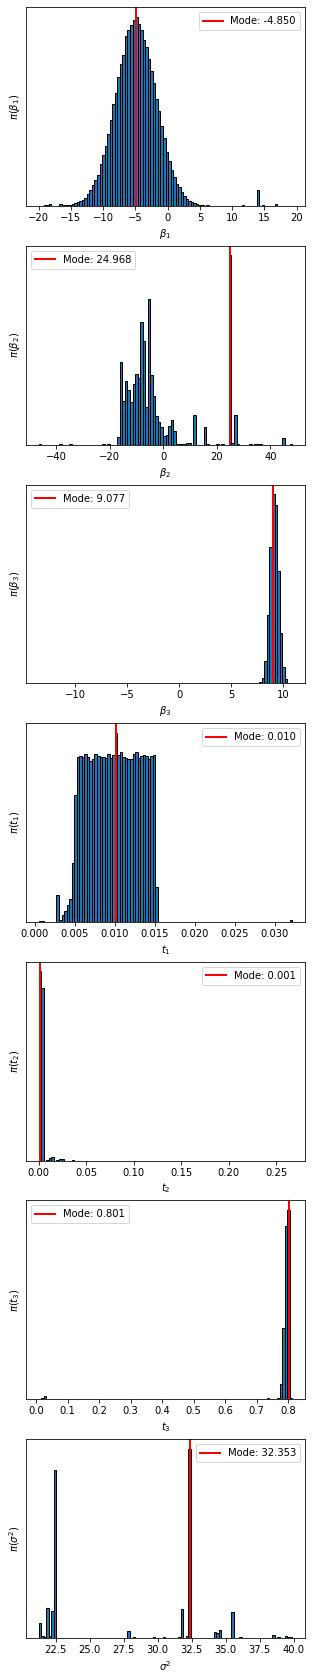

In [27]:
fig, axes = plt.subplots(n_dim, figsize=(5, 30))
clippings = [20, 50, 15, 1, 1, 1, 40]

for i in range(n_dim):
    ax = axes[i]
    nn, bins, _ = ax.hist(samples_flat[np.abs(samples_flat[:, i])
                                           < clippings[i], i], bins=100,
                          edgecolor='k', density=True)
    max_bin = nn.argmax()
    mode = bins[max_bin:max_bin + 2].mean()
    ax.set_xlabel(labels[i])
    ax.axvline(mode, label=f"Mode: {mode:.3f}", color="red", lw=2)
    ax.legend()
    ax.set_ylabel(r"$\pi$(" + labels[i] + ")")
    ax.set_yticks([])

axs[0].set_title(r"Histogram of parameters using samples from all chains")
plt.show()

In [23]:
mean_values = np.mean(samples, axis=(0, 1))
print(f"Mean values in the marginalized distributions:")
for i in range(n_dim):
    txt = "{1} = ${0:.3f}$"
    txt = txt.format(mean_values[i], labels[i])
    display(Math(txt))

Mean values in the marginalized distributions:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [24]:
print("Median, 15th and 85th percentiles in the marginalized distributions:")
for i in range(n_dim):
    mcmc = np.percentile(samples_flat[:, i], [15, 50, 85])
    q = np.diff(mcmc)
    txt = "{3} = ${0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Median, 15th and 85th percentiles in the marginalized distributions:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

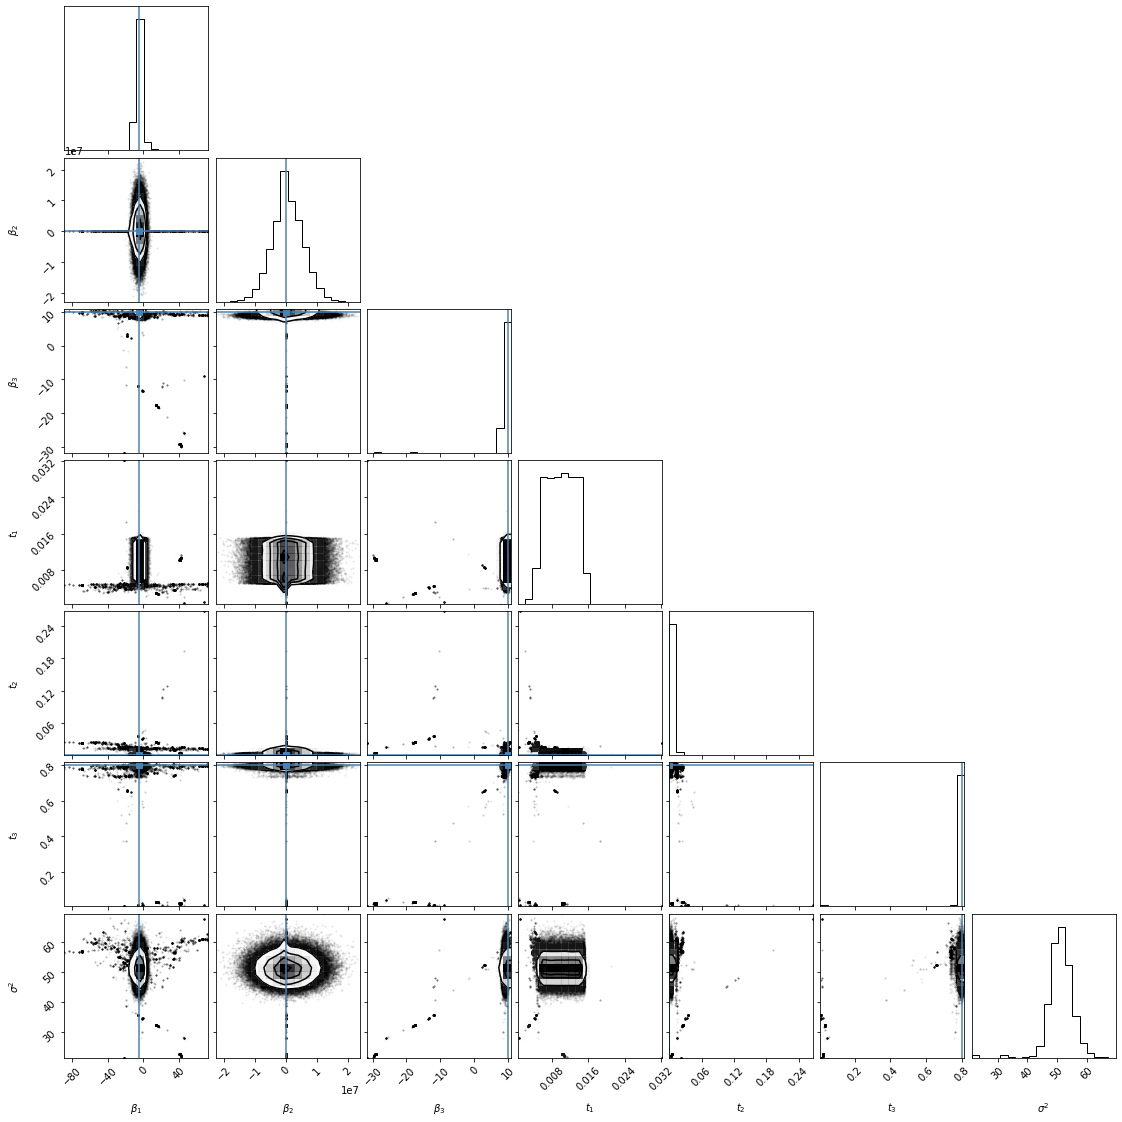

In [26]:
_ = corner.corner(samples_flat, labels=labels,
                  truths=[-5, 0, 10, 0.1, 0, 0.8, 0.25])

### Problems

1. The autocorrelation time is very high.
2. The value for $\sigma^2$ is not remotely correctly estimated.
3. The coefficient $\beta_2$ should be zero.
4. If we increase the variance, the chains need to be much longer to achieve convergence.

In [30]:
with open("sampler.mcmc", 'wb') as file:
    pickle.dump(sampler, file)
    file.close()

In [41]:
with open("sampler.mcmc", 'rb') as file:
    sampler = pickle.load(file)
    file.close()

## The PyMC library

In [17]:
import pymc3